# **Project №7 Lab journal**
## **Dead Man’s Teeth**
> Done by Ilia Popov

## **Part 1. Amplicon sequencing**

The output of the sequencing machine is a lot of fragments, each corresponding to a different molecule from the different species you are studying. Some of them are more abundant, some less; we don't know which yet, but now we're going to try to separate these fragments into several piles and try to show that sets of similar fragments originate from the same organism.
DNA sequences can be conservative: the same sequence can be found without too many changes in several species. That's why we cannot tell in advance whether a certain sequence we’ve amplified corresponds to a particular species or genus. For a particularly slow-evolving gene, we may not even be able to tell if it's in the same family! In this case, we can call each of these piles an “Operational Taxonomical Unit” or OTU, and then try to attribute it to one branch on the Tree of Life.

### **1) QIIME2 + other packages installation**

In [ ]:
! wget https://data.qiime2.org/distro/core/qiime2-2023.2-py38-linux-conda.yml
! conda env create -n qiime2-2023.2 --file qiime2-2023.2-py38-linux-conda.yml
! rm qiime2-2023.2-py38-linux-conda.yml
! conda activate qiime2-2023.2
! conda install kraken2 bwa samtools bedtools

### **2) Importing data**

Input files in very common EMP format - multiplexed file with reads and file with barcodes for demultiplexing. To import the regular FASTQ files, we need an additional “manifest file” (it’s in the same repository, next to reads). So, we are going to obtain single-end reads in FASTQ format with Phred33 encoding.

All data from the original research are available in the NCBI Short Read Archive (SRA) under number SRP029257 (BioProject PRJNA216965). In addition, all the data was uploaded to the server MG-RAST, an open source web application server that provides automatic phylogenetic and functional analysis of metagenomes. We are interested in data stored there in Project 365 - “Ancient Oral Metagenome”. Also all data is deposited [here](https://figshare.com/articles/dataset/_Dead_man_s_teeth_dataset/12152040).

SRA: SRP029257<br>
BioProject: PRJNA216965

In [1]:
! wget https://figshare.com/ndownloader/articles/12152040/versions/4 -O data.zip

--2024-03-28 00:48:41--  https://figshare.com/ndownloader/articles/12152040/versions/4
Resolving figshare.com (figshare.com)... 54.76.53.103, 54.73.41.93, 2a05:d018:1f4:d003:8a09:a9ea:f161:d4fe, ...
Connecting to figshare.com (figshare.com)|54.76.53.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20690324 (20M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  19.73M  3.47MB/s    in 9.1s    

2024-03-28 00:48:51 (2.18 MB/s) - ‘data.zip’ saved [20690324/20690324]



In [2]:
! unzip data.zip
! rm -rf data.zip

Archive:  data.zip
 extracting: manifest.tsv            
 extracting: sample-metadata.tsv     
 extracting: SRR957750.fastq         
 extracting: SRR957753.fastq         
 extracting: SRR957756.fastq         
 extracting: SRR957760.fastq         
 extracting: SRR986773.fastq         
 extracting: SRR986774.fastq         
 extracting: SRR986778.fastq         
 extracting: SRR986779.fastq         
 extracting: SRR986782.fastq         


In [3]:
! qiime tools import --type 'SampleData[SequencesWithQuality]' --input-path manifest.tsv --output-path sequences.qza --input-format SingleEndFastqManifestPhred33V2
! qiime tools validate sequences.qza

Imported manifest.tsv as SingleEndFastqManifestPhred33V2 to sequences.qza
Result sequences.qza appears to be valid at level=max.


### **3) Demultiplexing and QC**

_Note_: you can visualize any .qzv file at https://view.qiime2.org/

In [4]:
! qiime demux summarize --i-data sequences.qza --o-visualization sequences.qzv

Saved Visualization to: sequences.qzv


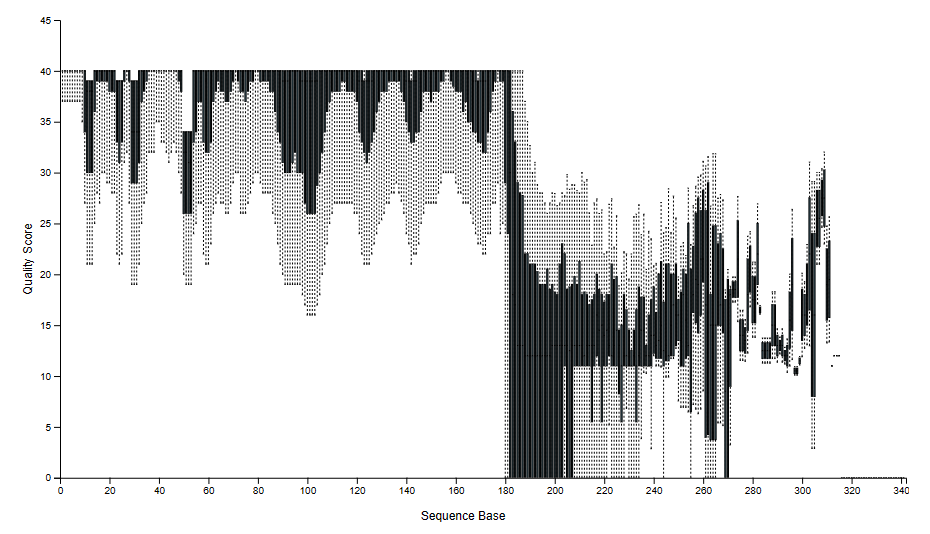

As we can see, the QC lowers at 180 bp, so we’ll trimm our sequences at 180 bases. A total length of the artificial sequences (barcode+primer) is 32, according to sample-metadata.tsv. Thus we will set further parameters:<br>
`--p-trim-left 32`<br>
`--p-trunc-len 150`

### **4) Feature table construction (and more QC)**

For the subsequent analysis we will need the metadata table (you can find it in the same repository). There is a barcode - a unique sequence in the beginning of each sample, and primer sequence, that was used to amplify the V5 region of the rRNA. We need to strip it out, and filter chimeric sequences.

In [5]:
! qiime dada2 denoise-single --i-demultiplexed-seqs sequences.qza \
    --p-trim-left 32 --p-trunc-len 150 --o-representative-sequences rep-seqs.qza \
        --o-table table.qza --o-denoising-stats stats.qza

Saved FeatureTable[Frequency] to: table.qza
Saved FeatureData[Sequence] to: rep-seqs.qza
Saved SampleData[DADA2Stats] to: stats.qza


In [6]:
! qiime metadata tabulate --m-input-file stats.qza \
    --o-visualization stats.qzv

Saved Visualization to: stats.qzv


In [7]:
! cat stats.qzv > metadata.zip
! unzip metadata.zip
! rm -rf metadata.zip

Archive:  metadata.zip
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/metadata.yaml  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/VERSION  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/checksums.md5  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/metadata.tsv  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/index.html  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/q2templateassets/css/base-template.css  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/q2templateassets/css/normalize.css  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/q2templateassets/css/bootstrap.min.css  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/q2templateassets/css/tab-parent.css  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/q2templateassets/fonts/glyphicons-halflings-regular.svg  
  inflating: 722939e2-7af8-4610-a148-ec4e11660131/data/q2templateassets/fonts/glyphicons-halflings-regular.woff  
  inflating: 722939e2-7af8-4610-a148-ec4e11

In [8]:
! mv 722939e2-7af8-4610-a148-ec4e11660131/data/metadata.tsv metadata.tsv

### **5) FeatureTable and FeatureData summaries**

First, let’s create visual summaries of the data - how many sequences are associated with each sample and with each feature, etc.

In [9]:
! qiime feature-table summarize   --i-table table.qza   --o-visualization table.qzv   --m-sample-metadata-file sample-metadata.tsv

Saved Visualization to: table.qzv


Then we can map feature IDs to sequences, to use these representative sequences in other applications, e.g. BLAST each sequence against the NCBI nt database.

In [10]:
! qiime feature-table tabulate-seqs --i-data rep-seqs.qza \
    --o-visualization rep-seqs.qzv

Saved Visualization to: rep-seqs.qzv


In [11]:
import pandas as pd

metatable = pd.read_csv("metadata.tsv", sep='\t', skiprows=[1])
metatable

,sample-id,input,filtered,percentage of input passed filter,denoised,non-chimeric,percentage of input non-chimeric
0,S10-V5-Q-B61-calc,5957,5648,94.81,5510,5389,90.46
1,S14-V5-P-B17-calc,4491,4240,94.41,4154,4122,91.78
2,S15-V5-R-B78-calc,4212,4012,95.25,3908,3693,87.68
3,S16S17-V5-K1-G12-root,5788,5588,96.54,5379,5379,92.93
4,S16S17-V5-K2-G12-root,5272,5022,95.26,4868,4868,92.34
5,S18S19-V5-L-B17-root,4955,4768,96.23,4643,4643,93.70
6,S20S21-V5-M-B61-root,5516,5374,97.43,5242,5184,93.98
7,S22S23-V5-N-B78-root,4695,4508,96.02,4360,4246,90.44
8,S8-V5-O-G12-calc,5362,5179,96.59,5054,4790,89.33


### **6) Taxonomic analysis**

Now we can compare the representative sequences with the taxonomy database, and get the answer to our first question: who lives here?<br>
First, we need the database itself:

In [12]:
! wget https://data.qiime2.org/2023.2/common/silva-138-99-nb-classifier.qza

--2024-03-28 00:54:38--  https://data.qiime2.org/2023.2/common/silva-138-99-nb-classifier.qza
Resolving data.qiime2.org (data.qiime2.org)... 54.200.1.12
Connecting to data.qiime2.org (data.qiime2.org)|54.200.1.12|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2023.2/common/silva-138-99-nb-classifier.qza [following]
--2024-03-28 00:54:39--  https://s3-us-west-2.amazonaws.com/qiime2-data/2023.2/common/silva-138-99-nb-classifier.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.152.240, 52.92.196.64, 52.92.195.152, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.152.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531637835 (507M) [binary/octet-stream]
Saving to: ‘silva-138-99-nb-classifier.qza’

silva-138-99-nb-cla 100%[===================>] 507.01M  3.13MB/s    in 2m 25s  

2024-03-28 00:57:06 (3.50 MB/s) - ‘silva-138-

In [13]:
! qiime feature-classifier classify-sklearn --i-classifier silva-138-99-nb-classifier.qza --i-reads rep-seqs.qza --o-classification taxonomy.qza

Saved FeatureData[Taxonomy] to: taxonomy.qza


#### **6.1) Visualization**

In [14]:
! qiime metadata tabulate --m-input-file taxonomy.qza --o-visualization taxonomy.qzv

Saved Visualization to: taxonomy.qzv


#### **6.2) Interactive barplot of taxonomic composition**

In [15]:
! qiime taxa barplot \
  --i-table table.qza \
  --i-taxonomy taxonomy.qza \
  --m-metadata-file sample-metadata.tsv \
  --o-visualization taxa-bar-plots.qzv

Saved Visualization to: taxa-bar-plots.qzv


#### **6.3) Export `ASV` table to `biom` file**

In [44]:
! qiime tools export --input-path table.qza --output-path export_biom

Exported table.qza as BIOMV210DirFmt to directory export_biom


#### **6.4) Export taxonomy table**

In [45]:
! qiime tools export --input-path  taxonomy.qza --output-path export_biom

Exported taxonomy.qza as TSVTaxonomyDirectoryFormat to directory export_biom


#### **6.5) Add taxonomy information to biom file**

In [46]:
! biom add-metadata -i export_biom/feature-table.biom \
    -o export_biom/feature-table-with-taxonomy.biom \
        --observation-metadata-fp export_biom/taxonomy.tsv \
            --sc-separated taxonomy --observation-header OTUID,taxonomy,confidence

#### **6.6) Fix header of the metadata file**

In [47]:
! sed  's/SampleID/NAME/g' sample-metadata.tsv   > sample-metadata.txt

Now we can use the “Marker data profiling” section of the [MicrobiomeAnalyst](https://www.microbiomeanalyst.ca/MicrobiomeAnalyst/ModuleView.xhtml) to explore your data in detail.  

## **Part 2. Shortgun sequensing**

We realized that 1000 years ago periodontal disease was caused by the same bacteria that we can find now in our mouth. But we know that bacteria evolve very quickly, and we have a unique opportunity to explore how it happens.

To investigate it, an affected individual G12 was selected for a dental calculus whole metagenome shotgun sequencing, and reads were assembled into contigs. Metagenome assembly is based on the same principles as for prokaryotic assemblies - usually it is a modification of existing algorithms, taking into account coverage (we expect similar coverage for each OTU) and less aggressive error correction (because in metagenomic samples it can be natural variants or close strain).

 We will skip the actual assembly process, because  the raw data is too large and it will take a lot of time (but you can download raw reads for this project from the [MG-RAST](https://www.mg-rast.org/mgmain.html?mgpage=download&metagenome=mgm4486544.3#generalInfo) or from the [SRA](https://www.ncbi.nlm.nih.gov/sra/SRX340014%5Baccn%5D) database  to assemble it on your own). Assembly results can be downloaded [here](https://www.dropbox.com/s/f5j52tliumt6etm/G12_assembly.fna.gz?dl=0), or also from the corresponding [MG-RAST](https://www.mg-rast.org/mgmain.html?mgpage=download&metagenome=mgm4530391.3) page.

In [21]:
! wget https://www.dropbox.com/s/f5j52tliumt6etm/G12_assembly.fna.gz

--2024-03-28 01:26:33--  https://www.dropbox.com/s/f5j52tliumt6etm/G12_assembly.fna.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/f5j52tliumt6etm/G12_assembly.fna.gz [following]
--2024-03-28 01:26:34--  https://www.dropbox.com/s/raw/f5j52tliumt6etm/G12_assembly.fna.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f21798ba66a01d8d7a4845f04.dl.dropboxusercontent.com/cd/0/inline/CP4RNfcKqtd0Al4_XQ4TiT1kqTOFfH_Qm6g3bOyrmarCLdghW1DvLngi13fYnSYeHJVYLzqhcmhgGr-KShdDQ_hbYaUXurIGPkh9tZkItl9YC8Wiq9we80e4XJCRa25cM5w/file# [following]
--2024-03-28 01:26:34--  https://uc7f21798ba66a01d8d7a4845f04.dl.dropboxusercontent.com/cd/0/inline/CP4RNfcKqtd0Al4_XQ4TiT1kqTOFfH_Qm6g3bOyrmarCLdghW1DvLngi13fYnSYeHJVYLzqhcmhgGr-KShdDQ_hbYaUXurIGPkh

In [22]:
! gunzip G12_assembly.fna.gz

### **1) Shotgun sequence data profiling**

We can classify reads to understand the composition of our samples in more detail - bacteria, viruses and eukaryotes as well. There are several tools and approaches for that, we will try kmer-based `Kraken2`.<br>
`Kraken2` is trying to assign the reads to different taxa based on a reference database of genomes. It works by comparing the k-mers in the reads to the k-mers in the reference database to determine the taxonomic origin of the reads.


In [ ]:
! kraken2-build --standard --db StandardDB

In [ ]:
! kraken2 --db StandardDB --output SRR957742_reads_kraken.out --report SRR957742_reads.report *.fastq


### **2) Visualization of the Kraken results as a Sankey diagram**

I will use the [`Pavian`](https://fbreitwieser.shinyapps.io/pavian/) web application to visualise the classification results obtained with `Kraken`. It can also accept input from other commonly used classifiers such as `Metaphlan` and `Centrifuge`.

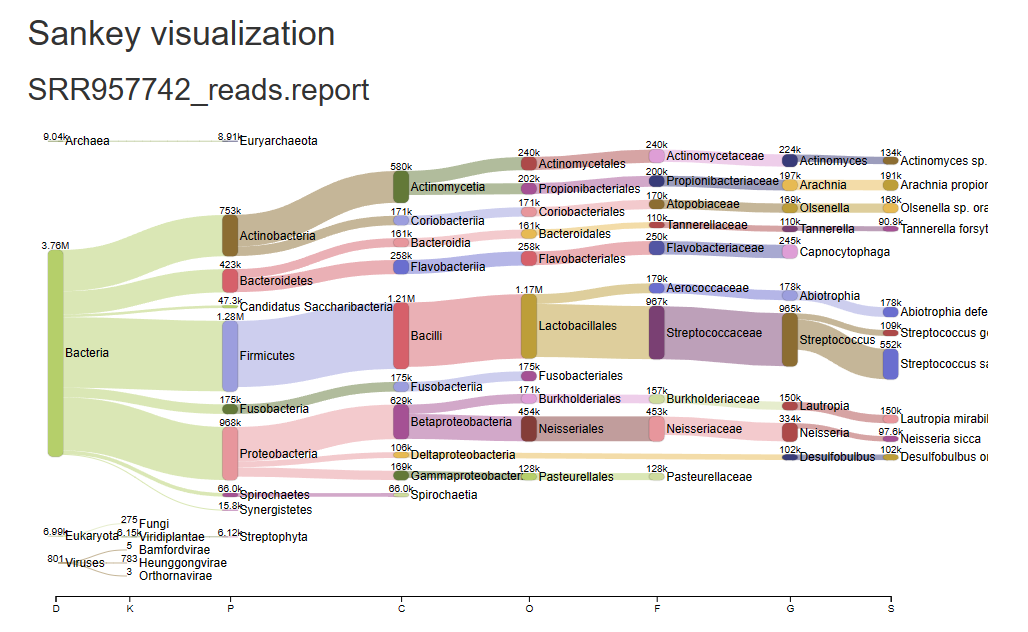

### **3) Comparison with ancient _Tannerella forsythia_ genome**

Our shotgun assembly is still pretty fragmented, so we will have to align our contigs to reference. Download data for the [_T. forsythia_](https://www.ncbi.nlm.nih.gov/nuccore/NC_016610.1/) strain - we will need the genome itself (`fasta`) and annotation (`GFF3`).

In [17]:
! esearch -db nucleotide -query "NC_016610.1" | efetch -format fasta > tannerella_forsythia_92A2.fasta
! esearch -db nucleotide -query "NC_016610.1" | efetch -format gff3 > tannerella_forsythia_92A2.gff3


#### **3.1) Indexing reference genome**

In [19]:
! bwa index tannerella_forsythia_92A2.fasta

[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.99 seconds elapse.
[bwa_index] Update BWT... 0.02 sec
[bwa_index] Pack forward-only FASTA... 0.02 sec
[bwa_index] Construct SA from BWT and Occ... 0.43 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index tannerella_forsythia_92A2.fasta
[main] Real time: 1.705 sec; CPU: 2.081 sec


#### **3.2) Aligning contigs and sorting**

In [23]:
! bwa mem tannerella_forsythia_92A2.fasta \
    G12_assembly.fna | samtools sort -o G12_assembly.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 33142 sequences (10000684 bp)...
[M::process] read 34258 sequences (10000241 bp)...
[M::mem_process_seqs] Processed 33142 reads in 6.168 CPU sec, 6.092 real sec
[M::process] read 35404 sequences (10000120 bp)...
[M::mem_process_seqs] Processed 34258 reads in 6.222 CPU sec, 6.148 real sec
[M::process] read 36534 sequences (10000152 bp)...
[M::mem_process_seqs] Processed 35404 reads in 6.366 CPU sec, 6.262 real sec
[M::process] read 38278 sequences (10001697 bp)...
[M::mem_process_seqs] Processed 36534 reads in 6.372 CPU sec, 6.311 real sec
[M::process] read 38866 sequences (10000030 bp)...
[M::mem_process_seqs] Processed 38278 reads in 6.285 CPU sec, 6.177 real sec
[M::process] read 40534 sequences (10000318 bp)...
[M::mem_process_seqs] Processed 38866 reads in 6.261 CPU sec, 6.203 real sec
[M::process] read 42182 sequences (10000459 bp)...
[M::mem_process_seqs] Processed 40534 reads in 6.315 CPU sec, 6.229 real sec
[M::pr

#### **3.3) Getting basic statistics**

In [24]:
! samtools flagstat G12_assembly.bam

905742 + 0 in total (QC-passed reads + QC-failed reads)
905601 + 0 primary
0 + 0 secondary
141 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
16539 + 0 mapped (1.83% : N/A)
16398 + 0 primary mapped (1.81% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


#### **3.4) Index alignment file**

In [35]:
! samtools index G12_assembly.bam

#### **3.5) Converting `.bam` to `.bed`**

In [36]:
! bedtools bamtobed -i G12_assembly.bam > G12_assembly.bed

#### **3.6) Intersecting alignment with genome annotation file**

In [37]:
! bedtools intersect -v -a tannerella_forsythia_92A2.gff3 \
    -b G12_assembly.bed > ref_G12_intersect.gff

In [1]:
! grep -e 'CDS' ref_G12_intersect.gff | cut -f9 | awk -F ';product=' \
    '{print $2}' | cut -d';' -f1 | sort | uniq > products.txt

In [39]:
! grep -e 'CDS' ref_G12_intersect.gff | cut -f9 | awk -F ';locus_tag=' \
'{print $2}' | cut -d';' -f1 | wc -l

194
